# 任务:对11种中药进行分类

## 导入工具包

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from PIL import Image
from torchvision import transforms,models,datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from torch.utils.tensorboard import SummaryWriter # Tensorboard可视化训练过程

plt.rcParams['font.sans-serif'] = ['SimHei'] # matplotlib需要设置中文font

## 数据读取与预处理操作

In [2]:
data_dir = './medicines_data2' # root目录
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

## 制作数据源
- data_transforms中指定了所有图像预处理操作
- ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存储同一类别的图片，文件夹的名字为分类的名字
- ImageFolder具体格式可以参考PyTorch官网
- 预处理部分进行了数据增强（Data Augmentation）：通过旋转翻转等方法获取更多的数据

In [3]:
data_transforms = {
    # 训练集进行数据增强操作--->解决数据量较少问题
    'train': transforms.Compose([
        transforms.RandomRotation(90), # 随机旋转，-90度到90度之间
        transforms.CenterCrop(224),  # 从中心开始裁剪    ResNet要求输入的数据为224*224
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转 p为是否翻转的概率
        transforms.RandomVerticalFlip(p=0.5), # 随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 亮度，对比度，饱和度，色相
        transforms.RandomGrayscale(p=0.025), # 概率转换为灰度图，3通道就是RGB
        transforms.ToTensor(), # 转换为Tensor格式
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # 标准化：均值，标准差，数值为实验常用
    ]),
    # 验证集不需要进行数据增强
    'valid':transforms.Compose([
        transforms.RandomRotation(90),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
}
data_transforms

{'train': Compose(
     RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
     CenterCrop(size=(224, 224))
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.5)
     ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
     RandomGrayscale(p=0.025)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'valid': Compose(
     RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
     Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [4]:
batch_size = 8 # batch_size为一次取出数据的量，建议设为2^n（最好不超过256）

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train','valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','valid']}
class_names = image_datasets['train'].classes

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 116
     Root location: ./medicines_data2\train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 43
     Root location: ./medicines_data2\valid
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
           

In [6]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x21587ac1cc0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x21587ac3a00>}

In [7]:
# 打印一下数据量
dataset_sizes

{'train': 116, 'valid': 43}

## 读取标签对应中药的名字

In [8]:
# 如果读取路径有中文名，需加上encoding='utf-8'
with open('info2.json','r',encoding='utf-8') as f:
    medicines_to_name = json.load(f)

In [9]:
medicines_to_name

{'1': '橘红',
 '2': '枸杞',
 '3': '甘草片',
 '4': '参片',
 '5': '黄芪',
 '6': '菊花',
 '7': '当归',
 '8': '金银花',
 '9': '三七花',
 '10': '西洋参'}

## 展示数据
- 注意tensor的数据需要转换为numpy的格式，而且需要还原回标准化的结果

In [10]:
def im_convert(tensor):
    """展示数据
        将处理后的tensor数据原路转换为numpy格式的数据
    """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0) # 因为PyTorch中第一个通道为颜色通道，所以需要使用transpose进行转换，对应位置进行更换(0,1,2)-->(1,2,0)
    image = image * np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406)) # 逆向归一化处理
    image = image.clip(0,1)
    
    return image

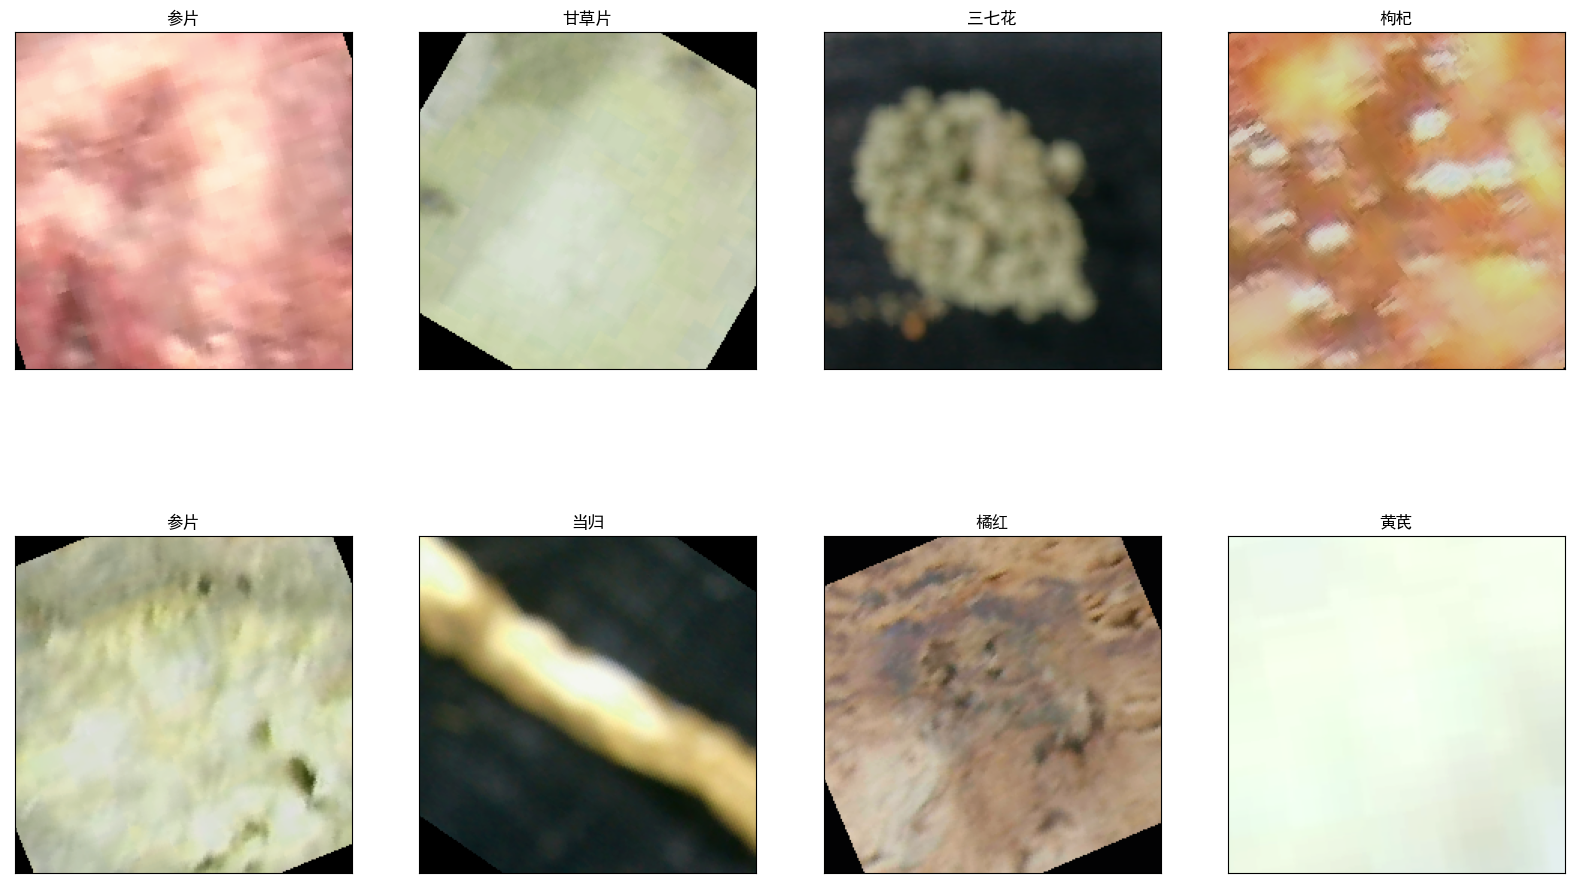

In [11]:
fig = plt.figure(figsize=(20,12))
columns = 4
rows = 2

dataiter = iter(dataloaders['train'])
inputs,classes = dataiter.__next__()

for idx in range(columns * rows):
    ax = fig.add_subplot(rows,columns,idx+1,xticks=[],yticks=[])
    ax.set_title(medicines_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

## 加载models中提供的模块，并且直接用训练好的权重当做初始化参数
- 第一次执行需要下载，如果过慢，可以直接将文件保存到指定的目录下
- 我电脑下载的位置C:\Users\22148\.cache\torch\hub\checkpoints
- 直接将官网下载pth后缀的文件，存入对应目录下即可

In [12]:
model_name = "resnet"
# 是否用人家训练好的特征来做
feature_extract = True

In [13]:
# 判断电脑是否能够支持GPU计算
# 我的电脑刚开始可以，后面就不行了，我也不知道为啥...
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU...不支持GPU')
else:
    print('CUDA is available! Training on GPU...支持GPU')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available! Training on GPU...支持GPU


In [14]:
"""设置训练过程需要更新的参数，默认中间的网络架构参数不更新"""
# 参考视频我先把函数放在这，用不用以后的事
def set_parameter_requires_grad(model,feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [15]:
# 使用了resnet50层的网络，可以换成其他的试试
model_ft = models.resnet50()
# 展示网络
# 说白了就是卷积层，池化层...不断重复
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

网络的最后一层为Linear(in_features=2048, out_features=1000, bias=True)，其中out_features为需要分类的类别数量，对应的就是我们要识别的中药数量
## 加载模型

In [16]:
def initialize_model(model_name,num_classes,feature_extract,weights=torchvision.models.ResNet50_Weights.DEFAULT):
    # 选择合适的模型，不同模型的初始化方法有区别
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """Resnet50
        """
        model_ft = models.resnet50(pretrained=True) # pretrained如果指定为True值，运行时并自动帮忙下载，之前的仅仅是网络架构
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.fc.in_features
        output_size = 10 # 设置需要分类的结果数量
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs,output_size),
                                   nn.LogSoftmax(dim=1) )
        input_size = 224
    """如果使用其他的网络就改变上面的model_name值，并多加几个判断，分支里的代码可以参考PyTorch官网"""
    return model_ft,input_size

## 设置哪些层需要训练

In [17]:
model_ft,input_size = initialize_model(model_name,10,feature_extract)

C:\Users\22148\.conda\envs\MachineLearning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\22148\.conda\envs\MachineLearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename = "C:\\Users\\22148\\Desktop\\Recognition of medicine\\Asunne3.pth"# 双\是为了解决字符转义导致的路径有误，我的电脑需要这样

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:") # 打印需要训练的层
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [19]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 优化器设置

In [20]:
# 优化器设置
"""优化器我参考视频选择了Adam，你们可以使用其他的试试看
    学习率采用了衰减策略
"""
optimizer_ft = optim.Adam(params_to_update,lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft,step_size=5,gamma=0.1)
# 最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss整合
criterion = nn.NLLLoss()

## 引入Tensorboard，可视化训练过程

In [21]:
writer = SummaryWriter("logs_train")

## 训练模块

In [22]:
def train_model(model,dataloaders,criterion,optimizer,num_epochs=10,is_inception=False,filename=filename):
    since = time.time() # 记录开始训练的时间
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)
    
    total_train_step = 0
    total_valid_step = 0
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # 开始迭代训练
    for epoch in range(num_epochs):
        print('正在进行第{}/{}轮训练'.format(epoch,num_epochs-1))
        print('-'*30)
        
        # 训练和验证
        for phase in ['train','valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            # 把数据都取个遍
            for inputs,labels in dataloaders[phase]:
                # 将数据读入GPU中进行训练，如果没有GPU，这一步可以舍去
                inputs = inputs.to(device)
                labels = labels.to(device)
                
#                 if phase=='train':
#                     total_train_step += 1
#                 if phase=='valid'
#                     total_valid_step += 1
                
#                 if total_train_step%20==0: # 每20次取数据记录一次
#                     writer.add_scalar("train_loss",)

                # 梯度清零
                optimizer.zero_grad()
                
                # 只有训练的时候计算和更新梯度
                # 参考PyTorch官网写法
                # 大致意思就是指定训练阶段更新梯度，验证阶段不进行更新
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs,aux_outputs = model(inputs)
                        loss1 = criterion(outputs,labels)
                        loss2 = criterion(aux_outputs,labels)
                        loss = loss1 + 0.4*loss2
                    else: # resnet执行此分支
                        outputs = model(inputs)
                        loss = criterion(outputs,labels)
                        
                    _, preds = torch.max(outputs,1)
                        
                    # 训练阶段更新权重
                    if phase == 'train':
                        # 反向传播，梯度更新
                        loss.backward()
                        optimizer.step()
                            
                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                
            time_elapsed = time.time() - since
            # 展示迭代一个epoch需要的时间
            print('Time elapsed {:.0f}s'.format(time_elapsed // 60,time_elapsed % 60))
            print('{}:总损失: {:.4f} 准确率: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            # 可视化损失函数的变化
            if phase=='train':
                writer.add_scalar("冻结所有层的train_loss",epoch_loss,epoch)
            if phase=='valid':
                writer.add_scalar("冻结所有层的valid_loss",epoch_loss,epoch)

            # 得到最好那次的模型
            if phase =='valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # 参考官网写法，复制最好的权重参数
                best_model_wts = copy.deepcopy(model.state_dict(),)
                # 模型保存对应的指标
                state = {
                    'state_dict':model.state_dict(),
                    'best_acc':best_acc,
                    'optimizer':optimizer.state_dict(),
                }
                torch.save(state,filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase =='train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
                    
        print('Optimizer learing rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
            
    time_elapsed = time.time()-since
    print('总训练时长:{:.0f}m {:.0f}s'.format(time_elapsed // 60,time_elapsed%60))
    print('最好的准确率:{:4f}'.format(best_acc))
    
    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model,val_acc_history,train_acc_history,valid_losses,train_losses,LRs

## 开始训练

In [23]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs = train_model(model_ft,dataloaders,criterion,optimizer_ft,num_epochs=100,is_inception=(model_name=='inception'))

正在进行第0/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 2.2474 准确率: 0.2586
Time elapsed 0s
valid:总损失: 2.1348 准确率: 0.3023
Optimizer learing rate : 0.0010000

正在进行第1/99轮训练
------------------------------


C:\Users\22148\.conda\envs\MachineLearning\lib\site-packages\torch\optim\lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time elapsed 0s
train:总损失: 1.8347 准确率: 0.3534
Time elapsed 0s
valid:总损失: 1.6818 准确率: 0.3953
Optimizer learing rate : 0.0010000

正在进行第2/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 1.8255 准确率: 0.4310
Time elapsed 0s
valid:总损失: 1.2050 准确率: 0.6279
Optimizer learing rate : 0.0010000

正在进行第3/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 1.4102 准确率: 0.4310
Time elapsed 0s
valid:总损失: 1.0283 准确率: 0.6977
Optimizer learing rate : 0.0010000

正在进行第4/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 1.1476 准确率: 0.6293
Time elapsed 0s
valid:总损失: 0.8813 准确率: 0.7907
Optimizer learing rate : 0.0010000

正在进行第5/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 1.1229 准确率: 0.6034
Time elapsed 0s
valid:总损失: 0.7973 准确率: 0.7209
Optimizer learing rate : 0.0010000

正在进行第6/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 0.9791 准确率: 0.6466
Time elapsed 0s
valid:总损失: 0.7843 准确率: 0.7442
Optimizer learing rate : 0.0010000

正在进行第7/99轮训练

Time elapsed 1s
train:总损失: 0.2797 准确率: 0.8966
Time elapsed 1s
valid:总损失: 0.2012 准确率: 0.9767
Optimizer learing rate : 0.0010000

正在进行第50/99轮训练
------------------------------
Time elapsed 1s
train:总损失: 0.3854 准确率: 0.9052
Time elapsed 1s
valid:总损失: 0.2161 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第51/99轮训练
------------------------------
Time elapsed 1s
train:总损失: 0.3129 准确率: 0.9138
Time elapsed 1s
valid:总损失: 0.3021 准确率: 0.9070
Optimizer learing rate : 0.0010000

正在进行第52/99轮训练
------------------------------
Time elapsed 1s
train:总损失: 0.2921 准确率: 0.9138
Time elapsed 1s
valid:总损失: 0.2300 准确率: 0.9070
Optimizer learing rate : 0.0010000

正在进行第53/99轮训练
------------------------------
Time elapsed 1s
train:总损失: 0.4225 准确率: 0.8793
Time elapsed 1s
valid:总损失: 0.3050 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第54/99轮训练
------------------------------
Time elapsed 1s
train:总损失: 0.4352 准确率: 0.8534
Time elapsed 1s
valid:总损失: 0.3078 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第55

Time elapsed 3s
train:总损失: 0.2725 准确率: 0.9052
Time elapsed 3s
valid:总损失: 0.2151 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第98/99轮训练
------------------------------
Time elapsed 3s
train:总损失: 0.3595 准确率: 0.8534
Time elapsed 3s
valid:总损失: 0.2425 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第99/99轮训练
------------------------------
Time elapsed 3s
train:总损失: 0.2935 准确率: 0.8966
Time elapsed 3s
valid:总损失: 0.1896 准确率: 0.9535
Optimizer learing rate : 0.0010000

总训练时长:3m 16s
最好的准确率:1.000000


验证损失变化
[2.2473702430725098, 1.8346637364091545, 1.825475470773105, 1.4101616103073646, 1.1475574600285496, 1.1228531393511543, 0.9790790163237473, 0.8813322905836434, 0.9234544984225569, 0.8583595834929367, 0.6538779077858761, 0.7678706974818789, 0.6320932445854976, 0.8084485119786756, 0.7432812914766115, 0.671983230730583, 0.5351659511697704, 0.5284977575828289, 0.5936292985389973, 0.5459034442901611, 0.6021779159019733, 0.4273633998015831, 0.4762969397265336, 0.48713750469273537, 0.4685221694666764, 0.5202177310812062, 0.40650468961945896, 0.704133196123715, 0.42578426003456116, 0.3532193734728057, 0.45479551060446377, 0.48423154703501997, 0.4911749928162016, 0.39874840296547986, 0.49469730463521233, 0.4514934605565564, 0.4353561272908901, 0.516060076910874, 0.3526391273942487, 0.4624197493339407, 0.39745514916962593, 0.29374172898202106, 0.40049546648716106, 0.36185833760376634, 0.36525887816116726, 0.37652022263099405, 0.30659520934368, 0.2612490181265206, 0.3802815516447199, 0.279

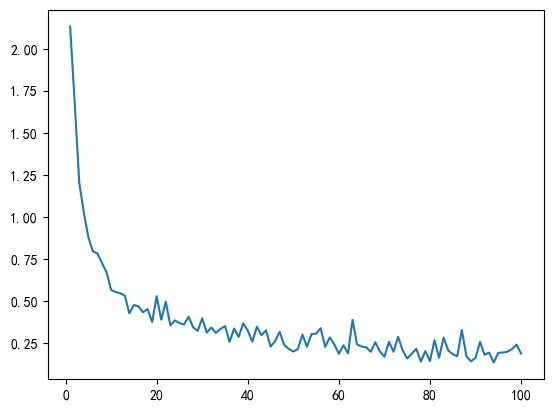

In [29]:
# print(val_acc_history)
X = []
for i in range(1,101):
    X.append(i)
X = np.array(X)
print('验证损失变化')
print(train_losses)
print(X)
plt.plot(X,valid_losses)
print('验证损失变化')
print(train_losses)
print('训练损失变化')
print(valid_losses)

## 再继续训练所有层

In [30]:
for param in model_ft.parameters():
    param.requires_grad = True
    
# 再继续训练所有的参数，学习率调小一点
optimizer=optim.Adam(params_to_update,lr=1e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer_ft,step_size=5,gamma=0.1)

# 损失函数
criterion = nn.NLLLoss()

In [31]:
#Load the checkpoing

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
#model_ft.class_to_idx = checkpoint['mapping']

In [32]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs = train_model(model_ft,dataloaders,criterion,optimizer_ft,num_epochs=100,is_inception=(model_name=='inception'))

正在进行第0/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 0.3066 准确率: 0.8966
Time elapsed 0s
valid:总损失: 0.1474 准确率: 1.0000
Optimizer learing rate : 0.0010000

正在进行第1/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 0.3677 准确率: 0.8793
Time elapsed 0s
valid:总损失: 0.1849 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第2/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 0.3289 准确率: 0.8966
Time elapsed 0s
valid:总损失: 0.3238 准确率: 0.9070
Optimizer learing rate : 0.0010000

正在进行第3/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 0.3029 准确率: 0.9052
Time elapsed 0s
valid:总损失: 0.2140 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第4/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 0.2914 准确率: 0.8707
Time elapsed 0s
valid:总损失: 0.1878 准确率: 0.9302
Optimizer learing rate : 0.0010000

正在进行第5/99轮训练
------------------------------
Time elapsed 0s
train:总损失: 0.3539 准确率: 0.8707
Time elapsed 0s
valid:总损失: 0.2017 准确率: 0.9302
Opti

Time elapsed 2s
valid:总损失: 0.1468 准确率: 0.9767
Optimizer learing rate : 0.0010000

正在进行第48/99轮训练
------------------------------
Time elapsed 2s
train:总损失: 0.2956 准确率: 0.8966
Time elapsed 2s
valid:总损失: 0.2420 准确率: 0.9070
Optimizer learing rate : 0.0010000

正在进行第49/99轮训练
------------------------------
Time elapsed 2s
train:总损失: 0.2423 准确率: 0.9052
Time elapsed 2s
valid:总损失: 0.1083 准确率: 0.9767
Optimizer learing rate : 0.0010000

正在进行第50/99轮训练
------------------------------
Time elapsed 2s
train:总损失: 0.2450 准确率: 0.9310
Time elapsed 2s
valid:总损失: 0.1093 准确率: 0.9535
Optimizer learing rate : 0.0010000

正在进行第51/99轮训练
------------------------------
Time elapsed 2s
train:总损失: 0.2411 准确率: 0.9310
Time elapsed 2s
valid:总损失: 0.1123 准确率: 0.9535
Optimizer learing rate : 0.0010000

正在进行第52/99轮训练
------------------------------
Time elapsed 2s
train:总损失: 0.1976 准确率: 0.9397
Time elapsed 2s
valid:总损失: 0.1813 准确率: 0.9767
Optimizer learing rate : 0.0010000

正在进行第53/99轮训练
------------------------------
Time ela

Time elapsed 4s
train:总损失: 0.2256 准确率: 0.9138
Time elapsed 4s
valid:总损失: 0.0649 准确率: 1.0000
Optimizer learing rate : 0.0010000

正在进行第96/99轮训练
------------------------------
Time elapsed 4s
train:总损失: 0.2103 准确率: 0.9138
Time elapsed 4s
valid:总损失: 0.1700 准确率: 0.9535
Optimizer learing rate : 0.0010000

正在进行第97/99轮训练
------------------------------
Time elapsed 4s
train:总损失: 0.2576 准确率: 0.9052
Time elapsed 4s
valid:总损失: 0.1855 准确率: 0.9767
Optimizer learing rate : 0.0010000

正在进行第98/99轮训练
------------------------------
Time elapsed 4s
train:总损失: 0.2558 准确率: 0.9138
Time elapsed 4s
valid:总损失: 0.0562 准确率: 1.0000
Optimizer learing rate : 0.0010000

正在进行第99/99轮训练
------------------------------
Time elapsed 4s
train:总损失: 0.4807 准确率: 0.7931
Time elapsed 4s
valid:总损失: 0.2777 准确率: 0.9302
Optimizer learing rate : 0.0010000

总训练时长:4m 17s
最好的准确率:1.000000


验证损失变化
[0.3066243827342987, 0.36772413089357575, 0.3289187406671458, 0.30289184892999715, 0.2914150460013028, 0.35390738526294974, 0.3618639640766999, 0.44114535944215183, 0.29604923737974004, 0.3296391260007332, 0.42379984593596953, 0.4031039008806492, 0.4972359538078308, 0.3844122627171977, 0.4940054552822277, 0.38829889739381857, 0.23241981375834037, 0.40129382600044383, 0.3239183510685789, 0.23499055797683782, 0.27691868281569976, 0.2545294327468708, 0.28628039360046387, 0.2316413768406572, 0.2517220119720903, 0.2696111585045683, 0.21812478684145828, 0.3855812192477029, 0.33545160447729044, 0.310357134146937, 0.2737261135259579, 0.2697898744252221, 0.33755234744528245, 0.2523436227749134, 0.28907538513685094, 0.29979650868937885, 0.3652721401946298, 0.3223797532505003, 0.1805494522740101, 0.20399947374545294, 0.1768440956185604, 0.18837097210103068, 0.24445635902470556, 0.27514889784928026, 0.27724304435582, 0.33155558958392717, 0.37419356135972615, 0.33484439705980235, 0.295563489

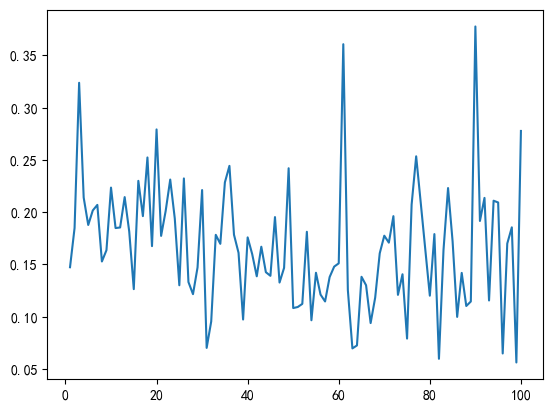

In [34]:
# print(val_acc_history)
X = []
for i in range(1,101):
    X.append(i)
X = np.array(X)
print('验证损失变化')
print(train_losses)
print(X)
plt.plot(X,valid_losses)
print('验证损失变化')
print(train_losses)
print('训练损失变化')
print(valid_losses)

## 加载训练好的模型

In [30]:
model_ft,input_size = initialize_model(model_name,102,feature_extract)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的目录+名字
filename='C:\\Users\\22148\\Desktop\\Recognition of medicine\\Asunne2.pth'

# 加载模型
Asunne = torch.load(filename)
best_acc = Asunne['best_acc']
model_ft.load_state_dict(Asunne['state_dict'])

<All keys matched successfully>

## 测试数据预处理
- 测试数据处理方法需要跟训练的一致
- crop操作的目的是保证输入的大小一致
- 标准化操作是必须的，用跟训练数据相同的mean和std，但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要归一化
- PyTorch中颜色通道是第一个维度，跟很多工具包不一样，需要转换

In [28]:
# def process_image(image_path):
#     # 读取测试数据
#     img = Image.open(image_path)
#     # Resize,thumbnail方法只能进行缩小，所以进行了判断
#     if img.size[0] > img.size[1]:
#         img.thumbnail((10000,256))
#     else:
#         img.thumbnail((256,10000))
#     # Crop操作
#     left_margin = (img.width-224)/2
#     bottom_margin = (img.height-224)/2
#     right_margin = left_margin + 224
#     top_margin = bottom_margin + 224
#     img = img.crop((left_margin,bottom_margin,right_margin,top_margin))
#     # 相同的预处理操作
#     img = np.array(img)/255
#     mean = np.array([0.485,0.456,0.406])# provided mean
#     std = np.array([0.229,0.224,0.225])# proviede std
#     img = (img-mean)/std
    
#     # 注意颜色通道应该放在第一个位置
#     img = img.transpose((2,0,1))# transpose更改通道位置 位置上进行更改(0,1,2)->(2,0,1)
    
#     return img

In [31]:
def imshow(image,ax=None,title=None):
    """展示数据"""
    if ax is None:
        fig,ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1,2,0))
    
    # 预处理操作
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = std * image + mean
    
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

In [30]:
# image_path = data_dir+'/test/微信图片_20230120030856.jpg' # 测试图像存放的位置
# img = process_image(image_path)
# imshow(img)

In [32]:
# # 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images,labels = dataiter.__next__()

model_ft.eval()

# 如果在GPU上进行训练，贼将数据放进GPU
if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)
    
# 可以输出一下output.shape观察结果,应为torch.size([x,y]) 其中x表示batch的数据量，y表示分类的总个数

## 得到概率最大的那个

In [33]:
_, preds_tensor = torch.max(output,1)
preds = np.squeeze(preds_tensor.numpy() if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy()))
preds

array([2, 0, 3, 4, 2, 4, 2, 3], dtype=int64)

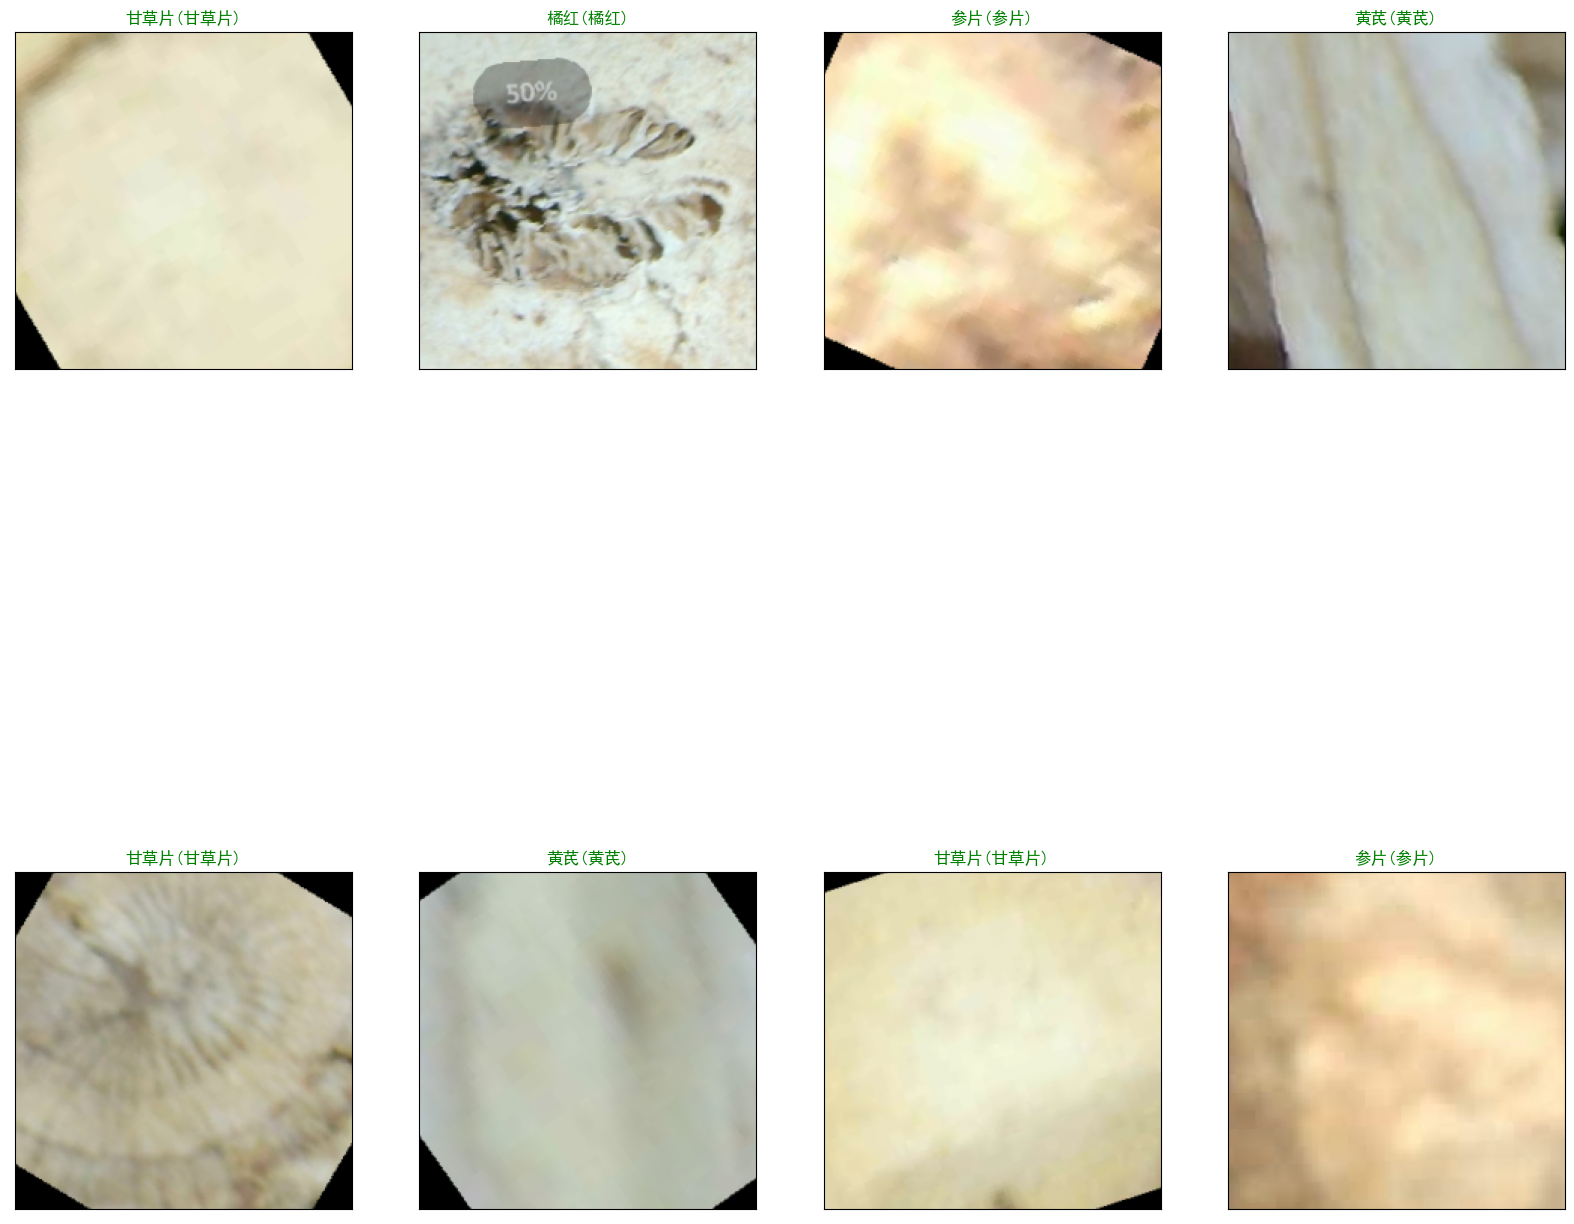

In [34]:
fig = plt.figure(figsize=(20,20))
columns = 4
rows = 2

for idx in range(columns*rows):
    ax = fig.add_subplot(rows,columns,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{0}({1})".format(medicines_to_name[str(preds[idx]+1)], medicines_to_name[str(labels[idx].item()+1)]),
                color=("green" if medicines_to_name[str(preds[idx]+1)]==medicines_to_name[str(labels[idx].item()+1)] else "red"))
plt.show()